In [1]:
#1) Import libraries
from qpsolvers import solve_qp
import time
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import Environments
import pandas as pd

In [2]:
#2) Create functions for quadratic computing
def H_funct(n):
    # H = np.zeros((3*n,3*n))
    H = np.diag([1e-3]*(3*n))
    for i in range(n):
        H[i*3+1,i*3+1] = 1
    return H

def Q_funct(n,vd):
    Q = np.zeros((3*n,))
    for i in range(n):
        Q[i*3+1]=-vd
    return Q

def A2_funct(n,dt):
    A = np.zeros((2*n+1,3*n))
    for i in range(0,2):
        A[i,i]=1
        A[i+2*(n-1),i+2*(n-1)+(n-1)]=0
    for i in range(2,2*n):
        j=i+(i//2)
        #if(i<2*(n-1)):
        A[i,j]=-1
        A[i,j-3]=1
        A[i,j-2]=dt
        if(i%2==0): 
            A[i,j-1]=dt**2 /2
    for i in range(2*n,2*n+1):
        j=i+(i//2)-3
        A[i,j]=1
    return A

def A_funct(n,dt):
    A = np.zeros((2*n+1,3*n))
    for i in range(0,2):
        A[i,i]=1
        A[i+2*(n-1),i+2*(n-1)+(n-1)]=0
    for i in range(2,2*n):
        j=i+(i//2)
        #if(i<2*(n-1)):
        A[i,j]=-1
        A[i,j-3]=1
        A[i,j-2]=dt
        if(i%2==0): 
            A[i,j-1]=dt**2 /2
    for i in range(2*n,2*n+1):
        j=i+(i//2)-3
        A[i,j+1]=1
    return A

def B2_funct(n,xi,xf):
    B = np.zeros((2*n+1,))
    B[0]=xi[0]
    B[1]=xi[1]
    B[2*n]=xf[0]
   # B[2*n+1]=xf[1]
    return B

def B_funct(n,xi,xf):
    B = np.zeros((2*n+1,))
    B[0]=xi[0]
    B[1]=xi[1]
    #B[2*n]=xf[0]
    B[2*n]=xf[1]
    return B

def bounds(n,bds):
    bounds= np.zeros((3*n))
    for i in range(n):
        bounds[i*3:i*3+3]=bds
    return bounds


In [3]:
#3) Quadratic programming model
class Model_QP():
    """
        Class: select action
        :param dt: time step
        :param lb: lower bounds [position, speed, acceleration]
        :param ub: upper bounds [position, speed, acceleration]
    """
    def __init__(self, dt, lb, ub):
        self.dt = dt
        self.lb = lb
        self.ub = ub
        
    def new_action_position(self, n, x_init, x_final):
        """
        New action : 
        :param n: number of steps
        :param x_init: initial position & speed
        :param x_final: final position & speed
        :return: [position, speed, acceleration]
        """ 
        H=H_funct(n)
        q=Q_funct(n,x_final[1])
        A=A2_funct(n,self.dt)
        B=B2_funct(n,x_init,x_final)
        lbs=bounds(n,self.lb)
        ubs=bounds(n,self.ub)
        return solve_qp(H, q, A=A, b=B, lb=lbs, ub=ubs)
    
    def new_action_speed(self, n, x_init, x_final):
        """
        New action : 
        :param n: number of steps
        :param x_init: initial position & speed
        :param x_final: final position & speed
        :return: [position, speed, acceleration]
        """ 
        H=H_funct(n)
        q=Q_funct(n,x_final[1])
        A=A_funct(n,self.dt)
        B=B_funct(n,x_init,x_final)
        lbs=bounds(n,self.lb)
        ubs=bounds(n,self.ub)
        return solve_qp(H, q, A=A, b=B, lb=lbs, ub=ubs)

In [173]:
#4) Rollout on the environment:
class Env_rollout:
    """ 
        Class : iterate on the environment
        :param env: our environment
        :param max_steps: max steps per episode
        :param dt: time step
        :param cross: size crosswalk
    """
    def __init__(self, env, max_steps, dt, cross):
        self.env = env
        self.max_steps = max_steps
        self.dt = dt
        self.cross = cross
        self.prev_state = env.reset()

    def iterations(self, model, nbr_episodes):
        """
        Iterate on the environment.
        :param model: current policy
        :param nbr_episodes: episode number
        :return: Tensors; state batch, action batch, reward batch
        """
        batch_obs=[]
        batch_acts=[]
        batch_rews=[]
        for ep in range(nbr_episodes):
            prev_state = env.reset()
            self.ds=prev_state[1]
            self.ped_speed=prev_state[3]
            for step_ep in range(self.max_steps):
                car_parameters=[0., 0., 0.]
                initial_state = prev_state[1:3][1::-1]
                if(prev_state[2]>=0. or prev_state[4]>=self.cross): # if car already pass the crosswalk
                    n=math.ceil((self.ds-prev_state[1])/(self.dt*2.0) +1)
                    if(self.ds-prev_state[1]>0.):
                        final_state = [prev_state[2]+n*self.ds*self.dt, self.ds]
                        car_parameters = model.new_action_speed(n, initial_state, final_state)
                        if(car_parameters is None):
                            print("Pass _ Initial state: "+str(initial_state))
                            print("Pass _ Final state: "+str(final_state))
                            print("Pass _ N: "+str(n))
                            car_parameters=[0., 0., 0.] 
                    
                elif(prev_state[3]<=0.05): # if pedestrian stops (not still cross)
                    car_parameters=[0., 0., prev_state[0]-0.2]
                    
                else:
                    n=1+math.ceil((self.cross-prev_state[4])/(self.dt*prev_state[3]))#,int((self.ds-prev_state[1])*self.dt/2.0)) #security factor
                    if(n==2):
                        acc=-2.*(prev_state[1]*self.dt + prev_state[2])/(self.dt**2)
                        car_parameters=[0., 0., np.clip([acc],-4.,2.)[0]]
                        #print(model.new_action_position(n, initial_state, final_state))
                    if(n==1):
                        car_parameters=[0., 0., 0.]
                        print("NOP")
                    if(n>2):
                        final_state = [0., self.ds]
                        car_parameters = model.new_action_position(n, initial_state, final_state)
                        #if(car_parameters is None):
                        #    print("Wait _ Initial state: "+str(initial_state))
                        #    print("Wait _ Final state: "+str(final_state))
                        #    print("Wait _ N: "+str(n))
                        while(car_parameters is None and n<10):
                            n=n+1
                            car_parameters = model.new_action_position(n, initial_state, final_state)
                            print("Change trajectory ... "+str(n))
                            #print((self.cross-prev_state[4]))
                            #car_parameters=[0., 0., 0.]
                        if(car_parameters is None):
                            car_parameters=[0., 0., 0.] 
            
                state, reward, done, _ = self.env.step(car_parameters[2:3])
                batch_obs.append(prev_state)
                batch_acts.append(car_parameters[2])
                batch_rews.append(reward)
                prev_state = state
                if done:
                    break
            avg_reward = np.mean(batch_rews[-10:])
            print("Episode * {} * Avg Reward is ==> {} And Number of steps is ==> {}".format(ep, avg_reward,ep))
        return batch_obs, batch_acts, batch_rews

In [174]:
#4) QP Algorithm:
class Algo_QP():
    """ 
    QP algorithm : testing
    :param policy_class: policy
    :param env: environment
    :param hyperparameters: other hyperparameters
    """
    def __init__(self, policy_class, env, **hyperparameters):
        
        self._init_hyperparameters(hyperparameters)
        self.model = policy_class(self.dt, self.l_b, self.u_b)
        self.rollout = Env_rollout(env, self.max_steps, self.dt, self.cross)
    
    def evaluate(self, nbr_episodes):
        """
        Testing
        :param nbr_episodes: episode number 
        :return: state batch, action batch, and reward batch
        """
        state_batch, action_batch, rewards_batch = self.rollout.iterations(self.model, nbr_episodes)
        return state_batch, action_batch, rewards_batch
    
    def _init_hyperparameters(self, hyperparameters):
        """
        Initialize hyperparameters. 
        :param hyperparameters: hyperparameter list
        """
        for param, val in hyperparameters.items():
            exec('self.' + param + ' = ' + str(val))
        self.num_algo = 1
        self.max_steps = 90
        self.total_loop = 0
        self.dt = 0.3
        self.cross = 5.0
            

In [175]:
#5) Computing part:
# Import environment
problem = "Crosswalk_comparisonQP-v0"
u_b = [2.0, 11.0, -22.5, 1.1, -1.0]
l_b = [-4.0, 9.0, -40.0, 0.9, -2.0]

env = gym.make(problem,dt=0.3,Vm=2.5,tau=1.0,lower_bounds=l_b, upper_bounds=u_b,simulation="unif")

# Initialize the algorithm
num_states = env.observation_space.shape[0]
num_actions = env.action_space.shape[0]
num_algo=1
u_b2=[200.0,15.0,2.0]
l_b2=[-45.0,0.0,-4.0]
algo=Algo_QP(Model_QP, env, num_algo= num_algo, num_states=num_states, num_actions=num_actions,l_b=l_b2, u_b=u_b2)
#algo.loading(1,1000)

C:\Users\abrunoud\Anaconda3\envs\ppotest\lib\site-packages\gym\logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


In [176]:
#Stock an evaluation sample
states, actions, rewards = algo.evaluate(1)
states=np.array(states)
ep_action=states[:,0]
ep_speed_car=states[:,1]
ep_pos_car=states[:,2]
ep_speed_ped=states[:,3]
ep_pos_ped=states[:,4]
ep_time=states[:,9]
ep_reward=rewards
t=0

Change trajectory ... 4
Episode * 0 * Avg Reward is ==> -3.115045397132159 And Number of steps is ==> 0


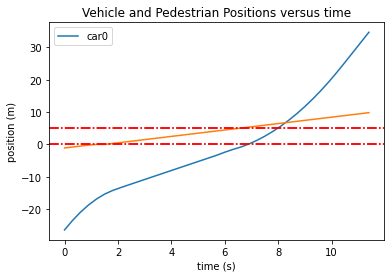

In [177]:
#Positions des agents
t=0
plt.title("Vehicle and Pedestrian Positions versus time")
plt.xlabel("time (s)")
plt.ylabel("position (m)")
j=0
while t+1<len(ep_time):
    t_init=t
    while t+1<len(ep_time) and ep_time[t]<ep_time[t+1]:
        t+=1
    plt.plot(ep_time[t_init:t],ep_pos_car[t_init:t], label="car"+str(j))
    plt.plot(ep_time[t_init:t],ep_pos_ped[t_init:t])
    plt.axhline(y=5, color='r', linestyle='-.')
    plt.axhline(y=0, color='r', linestyle='-.')
    t+=1
    j+=1
_=plt.axhline(y=5, color='r', linestyle='-.')
_=plt.axhline(y=0, color='r', linestyle='-.')
_=plt.legend()

In [178]:
#Show general information about the final algorithm performance: average speed, CO2 emission, end-time

LDV = pd.read_csv('LDV.csv', sep=';',names=["sp","acc","step","em_name","em_val"])
LDV.pop('step')
m = LDV == 0.0
LDV['acc'] = LDV['acc'].replace(1.27676e-15,0.0)
LDV['acc'] = LDV['acc'].astype(float)
LDV_array = np.array(LDV.values)

def info_co2(states,LDV):
    """
        Evaluate the CO2 emission per episode 
        :param states: state list
        :param LDV: CO2 emission chart
    """
    t=0
    total_emission=[]
    while t+1<len(ep_time):
        t_init=t
        emission_val=[]
        while t+1<len(ep_time) and ep_time[t]<ep_time[t+1]:
            acc=math.trunc(((states[t,0].item()//0.2)*0.2)*10.)/10.
            speed=math.trunc(((states[t,1].item()//0.5)*0.5)*10.)/10.
            cond=(LDV.sp==speed)&(LDV.acc==acc)&(LDV.em_name=="CO2")
            res=LDV[cond]['em_val'].item() *0.3
            emission_val.append(res)
            t+=1
        total_emission.append(np.sum(np.array(emission_val),axis=0))
        t+=1
    torch_total_emission=np.array(total_emission)
    total_emission_mean=np.mean(torch_total_emission)
    total_emission_std=np.std(torch_total_emission)
    print("\nThe average CO2 emission is {:.2f}mg and its standard deviation is {:.2f} mg".format(total_emission_mean.item(),total_emission_std.item()))
    
def get_average(states,LDV):
    ep_time=states[:,9]
    mean_speed=np.mean(states[:,1])
    sqrt_speed=np.std(states[:,1])
    print("The average car speed is {:.2f} m/s and its standard deviation is {:.2f} m/s".format(mean_speed.item(),sqrt_speed.item()))
    mean_acc=np.mean(states[:,0])
    sqrt_acc=np.std(states[:,0])
    print("\nThe average car acceleration is {:.2f} m/s2 and its standard deviation is {:.2f} m/s2".format(mean_acc.item(),sqrt_acc.item()))
    mean_speed_p=np.mean(states[:,3])
    sqrt_speed_p=np.std(states[:,3])
    print("\nThe average pedestrian speed is {:.2f} m/s2 and its standard deviation is {:.2f} m/s2".format(mean_speed_p.item(),sqrt_speed_p.item()))    
    mean_reward=np.mean(ep_reward)
    std_reward=np.std(ep_reward)
    print("\nThe average reward is {:.2f} and its standard deviation is {:.2f}".format(mean_reward.item(),std_reward.item()))
    info_co2(states,LDV) #CO2 info
    temps=[]
    t=0
    while t+1<len(ep_time):
        temps_i=np.array([0.,0.]) #respectively: end-time car/pedestrian
        t_init=t
        while t+1<len(ep_time) and ep_time[t]<ep_time[t+1]:
            if(states[t,2]<0.0 and states[t+1,2]>=0.0):
                temps_i[0]=(t-t_init)*0.3
            if(states[t,4]<5.0 and states[t+1,4]>=5.0):
                temps_i[1]=(t-t_init)*0.3
            t+=1
        if(temps_i[1]==0.0):
            temps_i[1]=(t-t_init)*0.3
        temps.append([(t-t_init)*0.3,temps_i[0],temps_i[1]])
        t+=1
    total_temps=np.array([temps]).reshape((-1,3))
    total_temps_mean=np.mean(total_temps,axis=0)
    print("\n Average End-times:")
    print("Total: {:.2f} s".format(total_temps_mean[0].item()))
    print("Car: {:.2f} s".format(total_temps_mean[1].item()))
    print("Pedestrian: {:.2f} s".format(total_temps_mean[2].item()))
get_average(states,LDV)

The average car speed is 5.61 m/s and its standard deviation is 2.99 m/s

The average car acceleration is -0.00 m/s2 and its standard deviation is 2.08 m/s2

The average pedestrian speed is 0.96 m/s2 and its standard deviation is 0.16 m/s2

The average reward is -2.22 and its standard deviation is 4.60


ValueError: can only convert an array of size 1 to a Python scalar

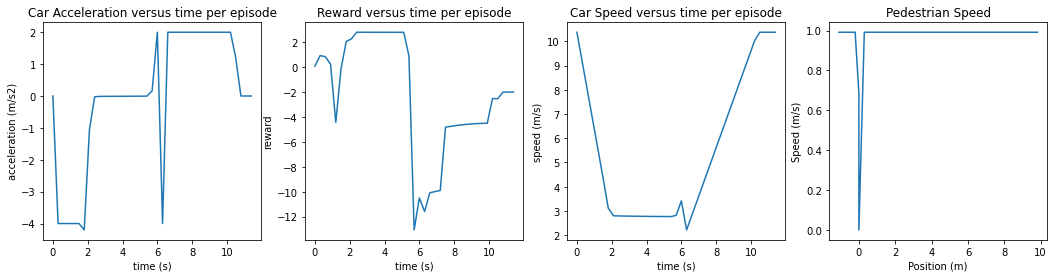

In [179]:
#Accélération, Reward, Vitesse de la voiture
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4,figsize=(18, 4))

t=0
ax1.set_title("Car Acceleration versus time per episode")
ax1.set_xlabel("time (s)")
ax1.set_ylabel("acceleration (m/s2)")

ax2.set_title("Reward versus time per episode")
ax2.set_xlabel("time (s)")
ax2.set_ylabel("reward")

ax3.set_title("Car Speed versus time per episode")
ax3.set_xlabel("time (s)")
ax3.set_ylabel("speed (m/s)")

ax4.set_title('Pedestrian Speed')
ax4.set_xlabel("Position (m)")
ax4.set_ylabel("Speed (m/s)")
while t+1<len(ep_time):
    t_init=t
    while t+1<len(ep_time) and ep_time[t]<ep_time[t+1]:
        t+=1
    ax1.plot(ep_time[t_init:t],ep_action[t_init:t])
    ax2.plot(ep_time[t_init:t],ep_reward[t_init:t])
    ax3.plot(ep_time[t_init:t],ep_speed_car[t_init:t])
    ax4.plot(states[t_init:t,4],states[t_init:t,3])
    t+=1
